# Аналитика в Яндекс.Афише

Оглавление :  

1. [Шаг 1. Изучение общей информации](#step1) 

2. [Шаг 2. Изучение продукта](#step2)  

    2.1 [Проверим, сколько людей пользуются в день/неделю/месяц](#step2.1)  
    
    2.2 [Проверим, сколько на сервисе сессий в день](#step2.2) 
    
    2.3 [Рассчитаем, сколько длится одна сессия](#step2.3) 
    
    2.4 [Вычислим, как часто люди возвращаются](#step2.4) 
    
3. [Шаг 3. Изучение продаж](#step3)

    3.1 [Вычислим, когда люди начинают покупать](#step3.1)
    
    3.2 [Посчитаем, сколько раз покупают за период](#step3.2)
    
    3.3 [Определим средний чек](#step3.3)
    
    3.4 [Рассчитаем, сколько денег приносят пользователи (LTV)](#step3.4)
    
4. [Шаг 4. Изучение маркетинга](#step4)   
    
    4.1 [Проверим, сколько денег потратили пользователи (всего / на каждый источник / по времени)](#step4.1)
    
    4.2 [Определим, сколько стоило привлечение одного покупателя из каждого источника](#step4.2)

    4.3 [Рассчитаем, на сколько окупились расходы (ROI)](#step4.3)

### Шаг 1. Изучение общей информации <a id="step1"></a> 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st

In [2]:
visits = pd.read_csv('projects/datasets/visits_log.csv')
orders = pd.read_csv('projects/datasets/orders_log.csv')
costs = pd.read_csv('projects/datasets/costs.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
308837,touch,2018-03-18 19:17:00,4,2018-03-18 18:55:00,1182050299838752466
347159,touch,2018-01-24 08:29:00,4,2018-01-24 08:28:00,11371846661300230134
222801,touch,2017-11-03 20:57:00,3,2017-11-03 20:47:00,5422619227112062724
111391,desktop,2018-02-10 22:18:00,4,2018-02-10 20:43:00,1006342040127892665
195820,desktop,2017-06-26 19:28:00,3,2017-06-26 19:23:00,255246909617571582


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
orders.sample(5)

,Buy Ts,Revenue,Uid
16045,2017-11-04 01:23:00,2.08,3612974943094492246
4896,2017-08-04 20:36:00,12.22,221880711661164670
14316,2017-10-24 12:48:00,2.20,3880307572277982999
33633,2018-02-08 20:33:00,3.91,2326423753463032677
28124,2018-01-04 23:19:00,1.22,10456700908718637038


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [8]:
costs.sample(5)

,source_id,dt,costs
1433,4,2018-05-13,145.15
2257,10,2017-08-18,16.98
339,1,2018-05-08,20.50
431,2,2017-08-08,56.98
1765,5,2018-04-11,136.88


In [9]:
visits.columns = visits.columns.str.lower()
visits.columns = ['device', 'end_session', 'source_id', 'start_session', 'uid']
orders.columns = orders.columns.str.lower()
orders.columns = ['order_time', 'revenue', 'uid']
costs.columns = ['source_id', 'date', 'costs']

In [10]:
visits['end_session'] = pd.to_datetime(visits['end_session'], format='%Y-%m-%d')
visits['start_session'] = pd.to_datetime(visits['start_session'], format='%Y-%m-%d')
orders['order_time'] = pd.to_datetime(orders['order_time'], format='%Y-%m-%d')
costs['date'] = pd.to_datetime(costs['date'], format='%Y-%m-%d')

In [11]:
visits.head()

,device,end_session,source_id,start_session,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [12]:
orders.head()

,order_time,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


### Вывод

Привели названия столбцов к нижнему регистру, преобразовали столбцы с датами к нужному типу.

### Шаг 2. Изучение продукта <a id="step2"></a> 

#### Проверим, сколько людей пользуются в день/неделю/месяц <a id="step2.1"></a> 

In [13]:
visits['session_year']  = visits['start_session'].dt.year
visits['session_month'] = visits['start_session'].astype('datetime64[M]')
visits['number_session_month'] = visits['start_session'].dt.month
visits['session_week']  = visits['start_session'].astype('datetime64[W]')
visits['number_session_week']  = visits['start_session'].dt.week
visits['session_date'] = visits['start_session'].dt.date

In [14]:
dau = visits.groupby('session_date').agg({'uid': 'nunique'})
wau = visits.groupby(['session_year', 'number_session_week']).agg({'uid': 'nunique'})
mau = visits.groupby(['session_year', 'number_session_month']).agg({'uid': 'nunique'})

In [15]:
dau_total = dau.mean()
wau_total = wau.mean()
mau_total = mau.mean()

In [16]:
print('Уникальных пользователей в день:', int(dau_total))
print('Уникальных пользователей в неделю:', int(wau_total))
print('Уникальных пользователей в месяц:', int(mau_total))

Уникальных пользователей в день: 907
Уникальных пользователей в неделю: 5716
Уникальных пользователей в месяц: 23228


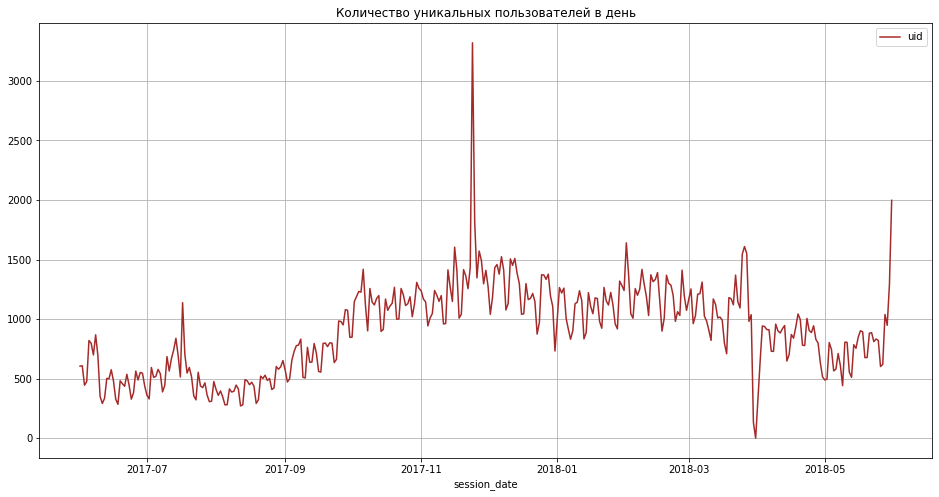

In [17]:
dau.plot(grid=True, color = '#a52a2a',
         figsize=(16,8), label='Количество пользователей', legend=True, title='Количество уникальных пользователей в день');

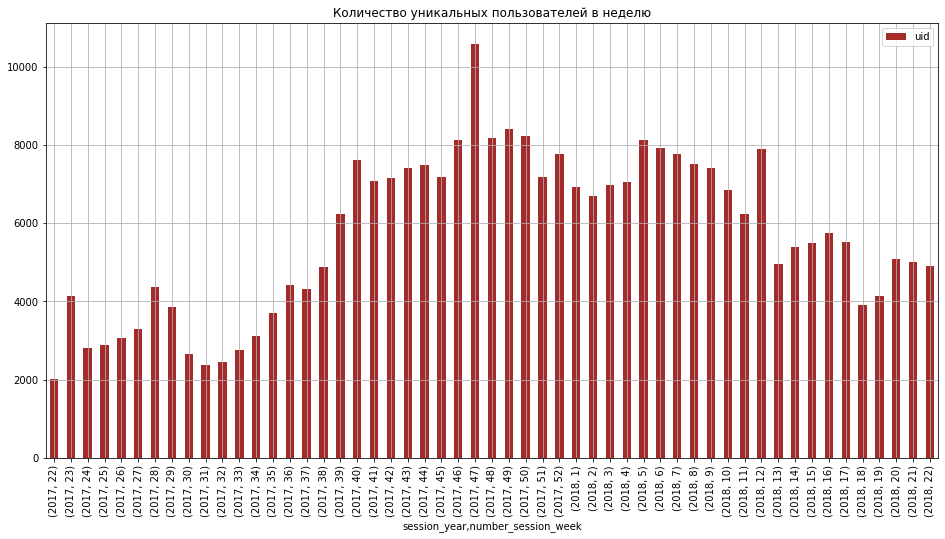

In [18]:
wau.plot(kind='bar', grid=True, color = '#a52a2a',
         figsize=(16,8), label='Количество пользователей', legend=True, title='Количество уникальных пользователей в неделю');

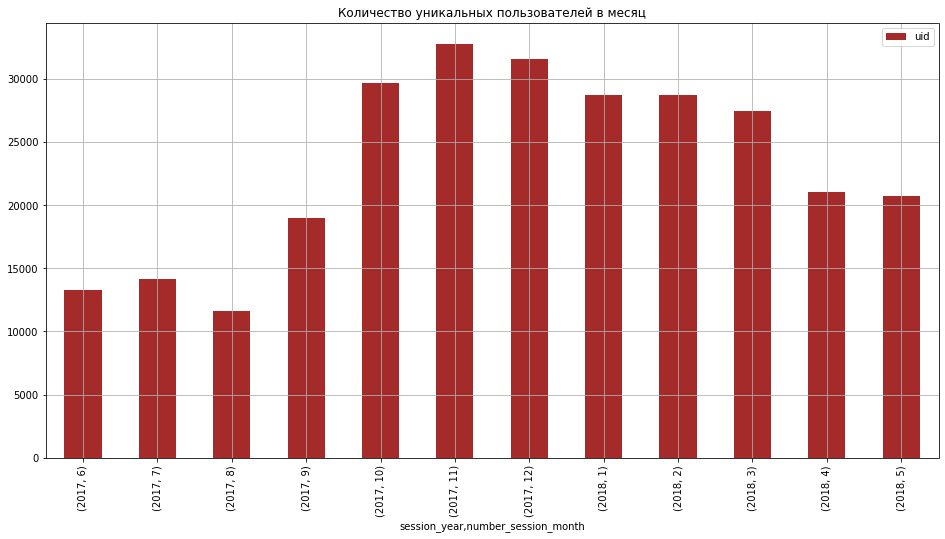

In [19]:
mau.plot(kind='bar', grid=True, color = '#a52a2a',
         figsize=(16,8), label='Количество пользователей', legend=True, title='Количество уникальных пользователей в месяц');

Проверим, с каких девайсов пользователи заходят на сайт:

In [20]:
dict_dates = {'number_session_week',
              'number_session_month'}

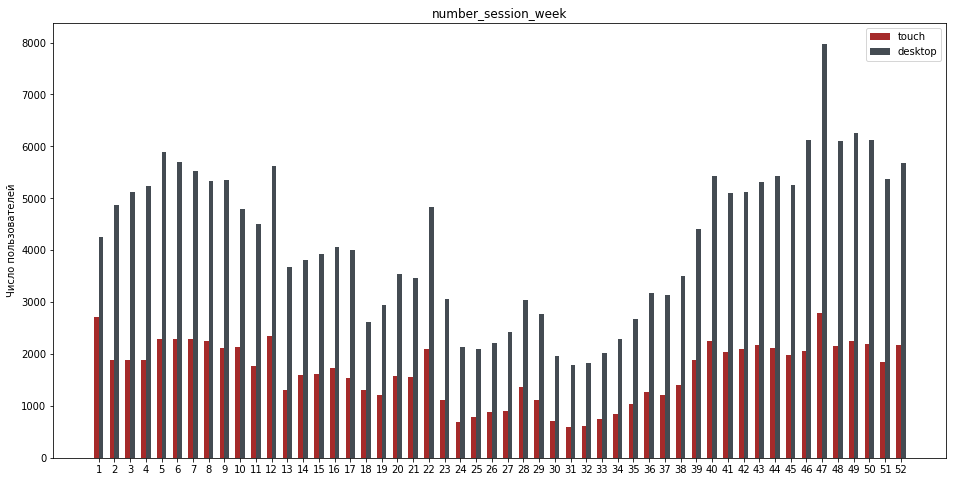

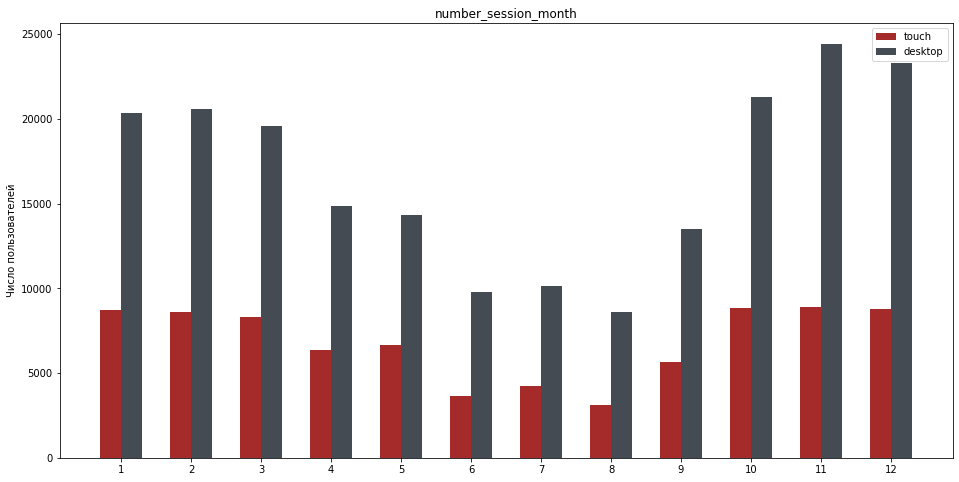

In [21]:
for column in dict_dates:
    date_devices = visits.groupby([column, 'device']).agg({'uid': 'nunique'}).reset_index()
    labels = date_devices[column].unique()
    date_devices = date_devices.set_index(column)
    touch = date_devices['uid'].loc[date_devices['device']=='touch']
    desktop = date_devices['uid'].loc[date_devices['device']=='desktop']
    
    x = np.arange(len(labels))
    width = 0.3

    fig, ax = plt.subplots(figsize=(16,8))
    rects1 = ax.bar(x - width/2, touch, width, label='touch', color='#a52a2a')
    rects2 = ax.bar(x + width/2, desktop, width, label='desktop', color='#444b52')
    
    ax.set_ylabel('Число пользователей')
    ax.set_title(column)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show() 
        

#### Проверим, сколько на сервисе сессий в день <a id="step2.2"></a> 

In [22]:
count_sessions = visits.groupby('session_date').agg({'uid': 'count'})

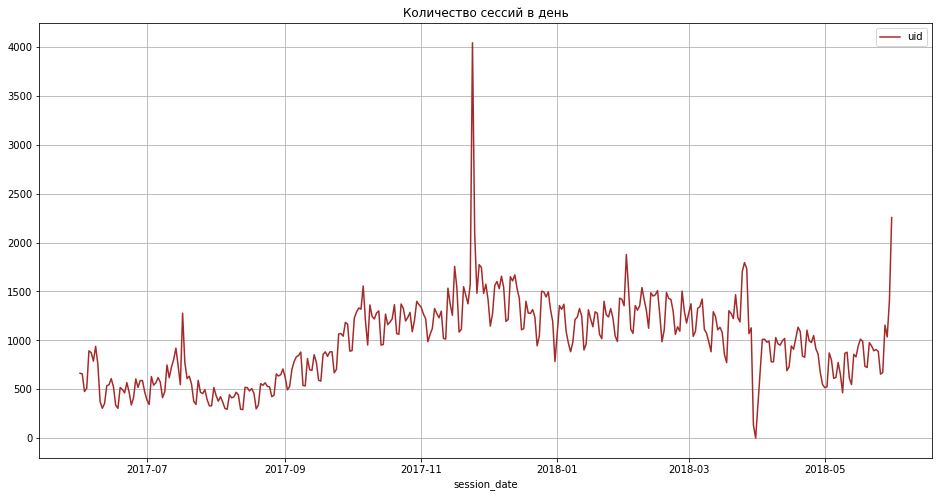

In [23]:
count_sessions.plot(grid=True, color = '#a52a2a',
         figsize=(16,8), label='Количество пользователей', legend=True, title='Количество сессий в день');

In [24]:
count_sessions_mean = count_sessions.mean()

In [25]:
print('Количество сессий в день:', int(count_sessions_mean))

Количество сессий в день: 987


In [26]:
month_count_sessions = visits.groupby(['session_year', 'number_session_month']).agg({'uid': 'count'})

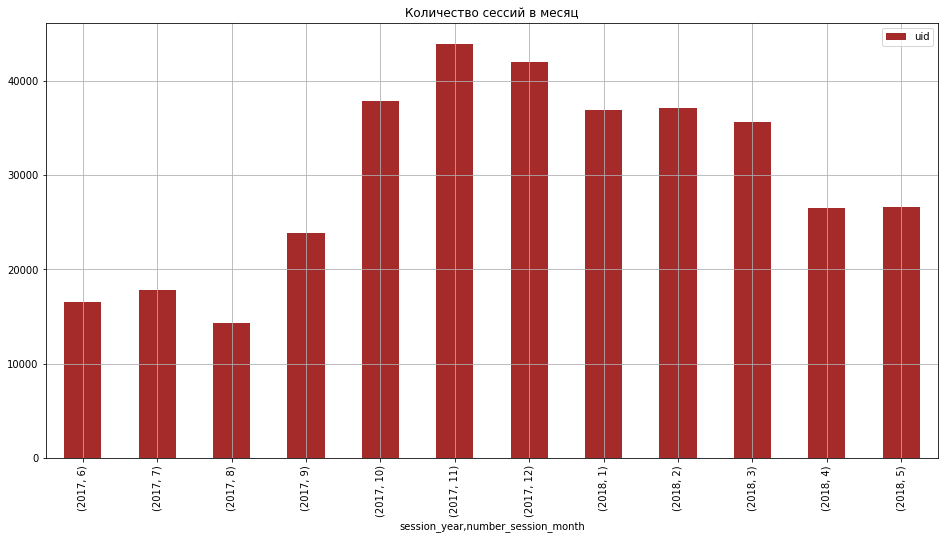

In [27]:
month_count_sessions.plot(kind='bar', grid=True, color = '#a52a2a',
         figsize=(16,8), label='Количество пользователей', legend=True, title='Количество сессий в месяц');

Посмотрим на этот показатель с разбивкой по устройствам:

In [28]:
month_session_devices = visits.groupby(['number_session_month', 'device']).agg({'uid': 'count'}).reset_index()

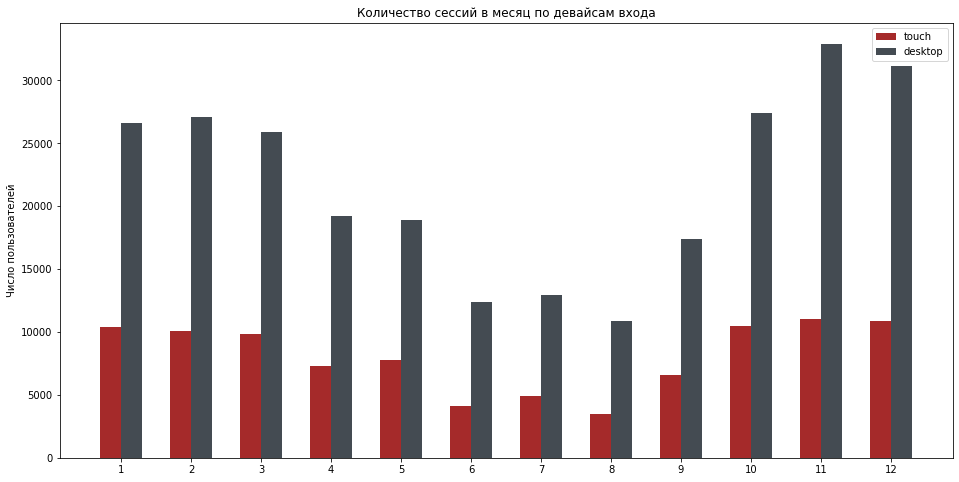

In [29]:
labels = month_session_devices['number_session_month'].unique()
month_session_devices = month_session_devices.set_index('number_session_month')
touch = month_session_devices['uid'].loc[month_session_devices['device']=='touch']
desktop = month_session_devices['uid'].loc[month_session_devices['device']=='desktop']
    
x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots(figsize=(16,8))
rects1 = ax.bar(x - width/2, touch, width, label='touch', color='#a52a2a')
rects2 = ax.bar(x + width/2, desktop, width, label='desktop', color='#444b52')
    
ax.set_ylabel('Число пользователей')
ax.set_title('Количество сессий в месяц по девайсам входа')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show();

#### Рассчитаем, сколько длится одна сессия  <a id="step2.3"></a> 

In [30]:
visits['session_duration_min'] = (visits['end_session'] - visits['start_session']).dt.total_seconds() / 60

In [31]:
visits['session_duration_min'].describe()

count    359400.000000
mean         10.717095
std          16.618796
min         -46.000000
25%           2.000000
50%           5.000000
75%          14.000000
max         711.000000
Name: session_duration_min, dtype: float64

In [32]:
visits = visits.query('session_duration_min >= 0')

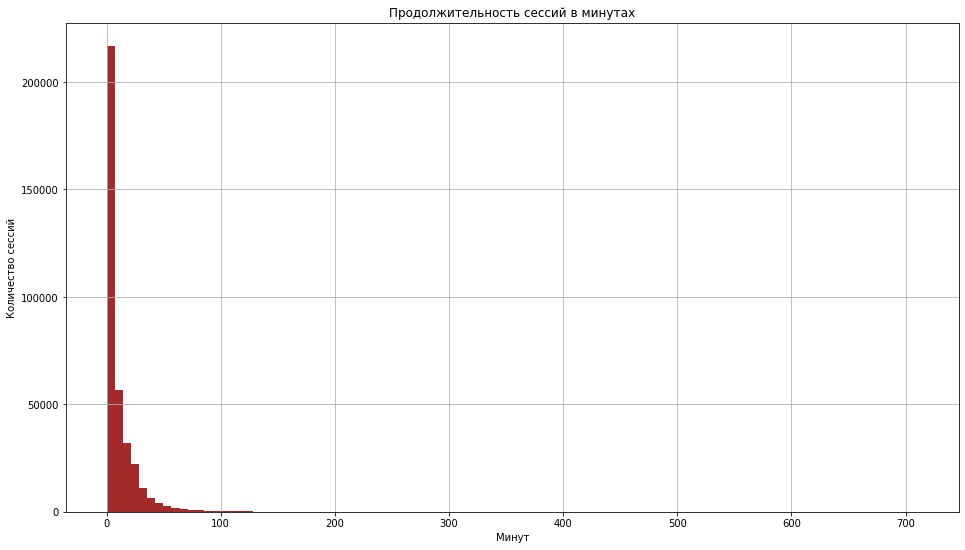

In [33]:
visits['session_duration_min'].hist(bins=100, color = '#a52a2a', figsize=(16, 9))
plt.xlabel('Минут')
plt.ylabel('Количество сессий')
plt.title('Продолжительность сессий в минутах')
plt.show();

In [34]:
print('Средняя длительность сессии в минутах:', visits['session_duration_min'].median())

Средняя длительность сессии в минутах: 5.0


#### Вычислим, как часто люди возвращаются <a id="step2.4"></a> 

In [35]:
first_visit = visits.groupby('uid')['start_session'].min().reset_index()
first_visit.columns = ['uid', 'first_session_date']

In [36]:
visits = visits.merge(first_visit, on='uid')

In [37]:
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')

In [38]:
cohort_sizes_visits = visits.groupby('first_session_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes_visits.columns = ['first_session_month', 'n_visitors']

In [39]:
cohort_sizes_visits

,first_session_month,n_visitors
0,2017-06-01,13259
1,2017-07-01,13140
2,2017-08-01,10181
3,2017-09-01,16704
4,2017-10-01,25977
5,2017-11-01,27248
6,2017-12-01,25268
7,2018-01-01,22624
8,2018-02-01,22197
9,2018-03-01,20589


In [40]:
visits['cohort_lifetime'] = (visits['session_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [41]:
cohort_visits = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [42]:
cohort_visits = cohort_visits.merge(cohort_sizes_visits,on='first_session_month')

In [43]:
cohort_visits['retention'] = cohort_visits['uid']/cohort_visits['n_visitors']

In [44]:
cohort_visits

,first_session_month,cohort_lifetime,uid,n_visitors,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03-01,1,861,20589,0.041818
74,2018-03-01,2,557,20589,0.027053
75,2018-04-01,0,15709,15709,1.000000
76,2018-04-01,1,760,15709,0.048380


In [45]:
retention_pivot = cohort_visits.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum')

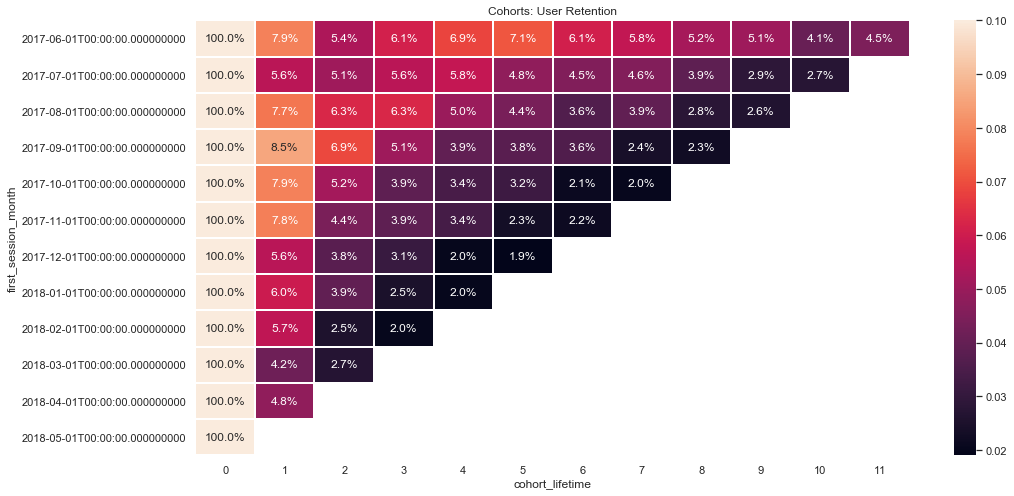

In [46]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, vmax=0.1);

### Вывод

В день заходят 907 уникальных пользователей, а сессий в день всего 987. Значит редкий пользователь заходит дважды. Зато средняя сессия достаточно длинная – 5 минут.

Пик посетителей был в конце ноября 2017 года, похоже, реклама черной пятницы (24 ноября) сработала :) А в конце марта 2018 трафик значительно просел (не было ли факапа?).

Основная масса пользователей заходит на сайт с десктопа, только треть визитов с мобильных устройств. Возможно, мобильный интерфейс не очень удобный (например, выбор места в зале становится трудной задачей для устройств с маленьким экраном), а может быть, пользователи предпочитают искать и покупать билеты с десктопа, потому что сравнивают сразу несколько агрегаторов. 

Что касается возврата пользователей к сайту, то, увы, процент возврата совсем низкий. Вероятно, сценарий поиска и покупки билетов не такой частый и пользователи редко это делают.

Пользователи 2017 года гораздо активнее возвращались к сайту в следующие месяцы жизни когорты.
Когорта 2017-06-01 имеет самые стабильные показатели возврата к сайту, у остальный когорт интерес падает быстрее.

### Шаг 3. Изучение продаж <a id="step3"></a> 

#### Вычислим, когда люди начинают покупать <a id="step3.1"></a> 

In [47]:
first_order = orders.groupby('uid')['order_time'].min().reset_index()
first_order.columns = ['uid', 'first_order_date']
first_order['first_order_month'] = first_order['first_order_date'].astype('datetime64[M]')

In [48]:
first_order

,uid,first_order_date,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-01
...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-11-01
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-01
36520,18445601152732270159,2018-03-26 22:54:00,2018-03-01
36521,18446156210226471712,2018-02-18 19:34:00,2018-02-01


In [49]:
time_to_first_order = first_order.merge(first_visit, how = 'inner', on='uid')

In [50]:
time_to_first_order['time_to_order'] = (time_to_first_order['first_order_date'] - time_to_first_order['first_session_date']).dt.seconds / 60

In [51]:
time_to_first_order['time_to_order'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_to_order, dtype: float64

In [52]:
time_to_first_order

,uid,first_order_date,first_order_month,first_session_date,time_to_order
0,313578113262317,2018-01-03 21:51:00,2018-01-01,2017-09-18 22:49:00,1382.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-01,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-01,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-01,2017-11-24 10:14:00,0.0
...,...,...,...,...,...
36518,18445147675727495770,2017-11-24 09:03:00,2017-11-01,2017-08-20 13:30:00,1173.0
36519,18445407535914413204,2017-09-22 23:55:00,2017-09-01,2017-09-22 23:48:00,7.0
36520,18445601152732270159,2018-03-26 22:54:00,2018-03-01,2017-08-07 11:51:00,663.0
36521,18446156210226471712,2018-02-18 19:34:00,2018-02-01,2017-11-07 10:01:00,573.0


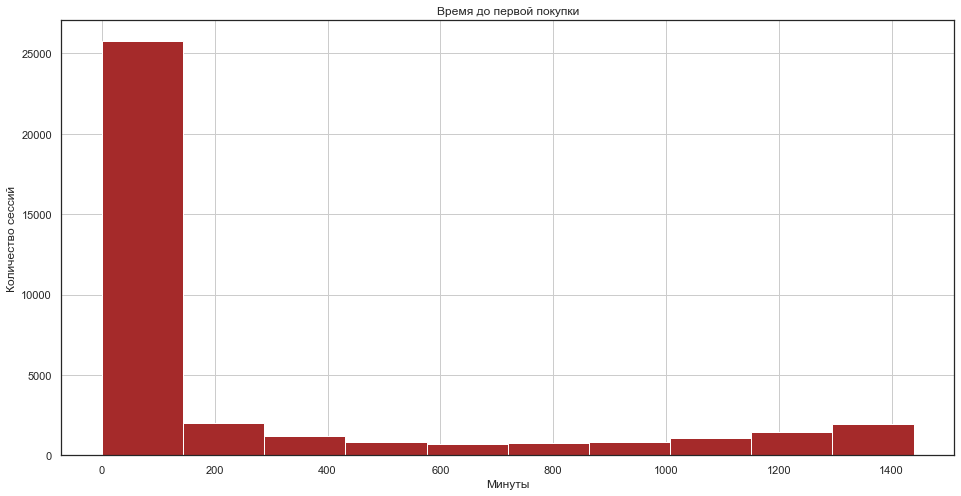

In [53]:
time_to_first_order['time_to_order'].hist(color = '#a52a2a', figsize=(16,8))
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')
plt.title('Время до первой покупки')
plt.show()

Проверим распределение в рамках 100 минут:

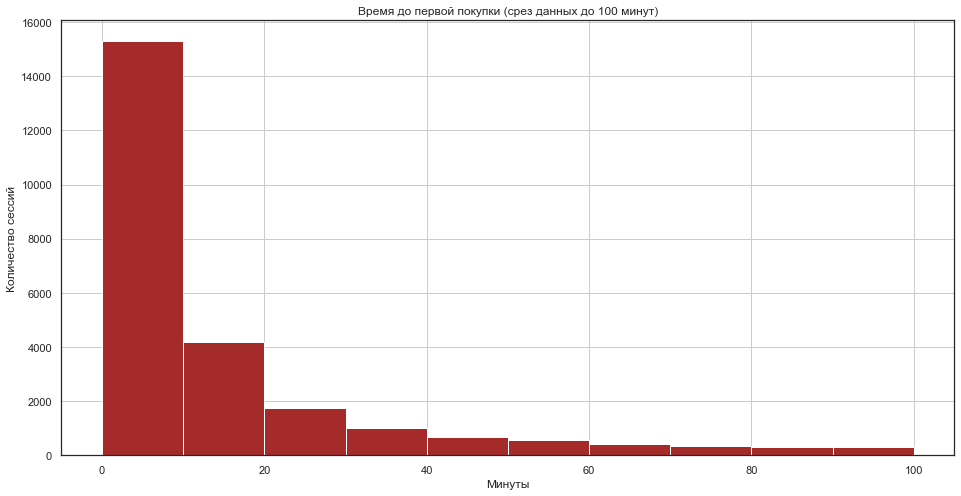

In [54]:
time_to_first_order['time_to_order'].hist(range=(0,100), color = '#a52a2a', figsize=(16,8))
plt.xlabel('Минуты')
plt.ylabel('Количество сессий')
plt.title('Время до первой покупки (срез данных до 100 минут)')
plt.show()

#### Посчитаем, сколько раз покупают за период <a id="step3.2"></a> 

In [55]:
orders['order_year'] = orders['order_time'].dt.year
orders['order_month'] = orders['order_time'].astype('datetime64[M]')
orders['order_week'] = orders['order_time'].astype('datetime64[W]')
orders['order_date'] = orders['order_time'].dt.date

In [56]:
orders.head()

,order_time,revenue,uid,order_year,order_month,order_week,order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,2017-06-01,2017-06-01


In [57]:
orders_per_year = orders.groupby('order_year').agg({'uid': 'count'})
orders_per_month = orders.groupby(['order_year', 'order_month']).agg({'uid': 'count'})
orders_per_week = orders.groupby(['order_year', 'order_month', 'order_week']).agg({'uid': 'count'})

In [58]:
orders_per_year

,uid
order_year,
2017,27467
2018,22948


In [59]:
orders_per_month

uid
order_year order_month      
2017       2017-06-01   2354
           2017-07-01   2363
           2017-08-01   1807
           2017-09-01   3387
           2017-10-01   5679
           2017-11-01   5659
           2017-12-01   6218
2018       2018-01-01   4721
           2018-02-01   5281
           2018-03-01   5326
           2018-04-01   3273
           2018-05-01   4346
           2018-06-01      1

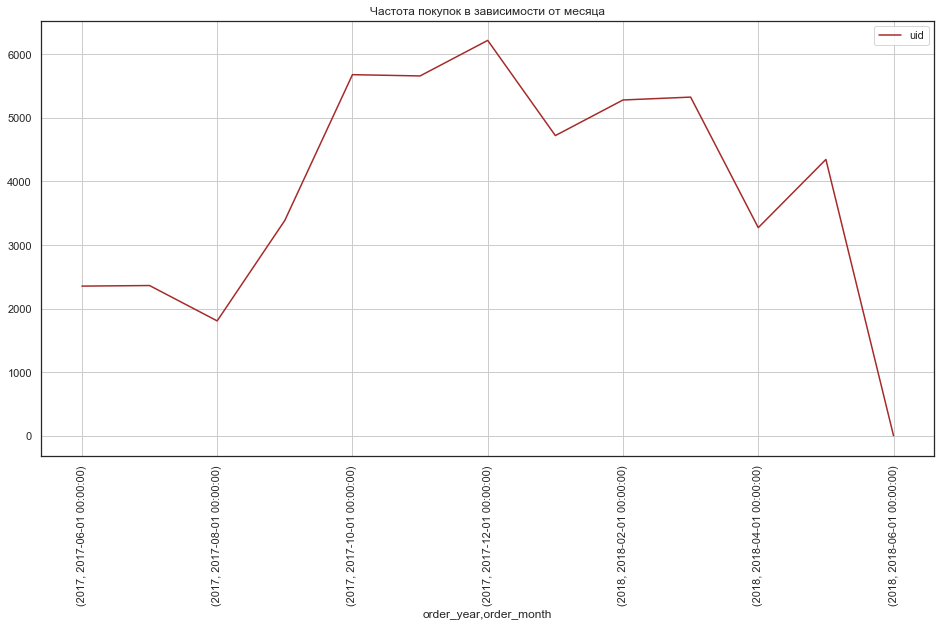

In [60]:
orders_per_month.plot(grid=True, color = '#a52a2a', rot=90,
         figsize=(16,8), label='Количество покупателей', legend=True, title='Частота покупок в зависимости от месяца');

In [61]:
orders_per_week

uid
order_year order_month order_week      
2017       2017-06-01  2017-06-01   896
                       2017-06-08   525
                       2017-06-15   341
                       2017-06-22   441
                       2017-06-29   151
...                                 ...
2018       2018-05-01  2018-05-10   734
                       2018-05-17  1156
                       2018-05-24  1086
                       2018-05-31   610
           2018-06-01  2018-05-31     1

[63 rows x 1 columns]

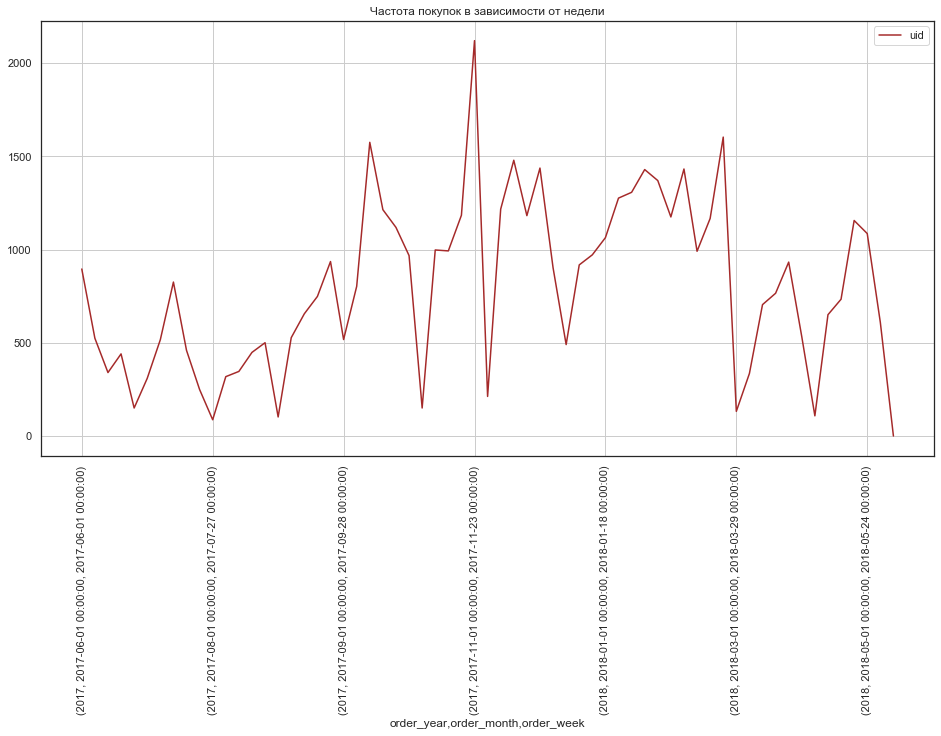

In [62]:
orders_per_week.plot(grid=True, color = '#a52a2a', rot=90,
         figsize=(16,8), label='Количество покупателей', legend=True, title='Частота покупок в зависимости от недели');

#### Определим средний чек <a id="step3.3"></a> 

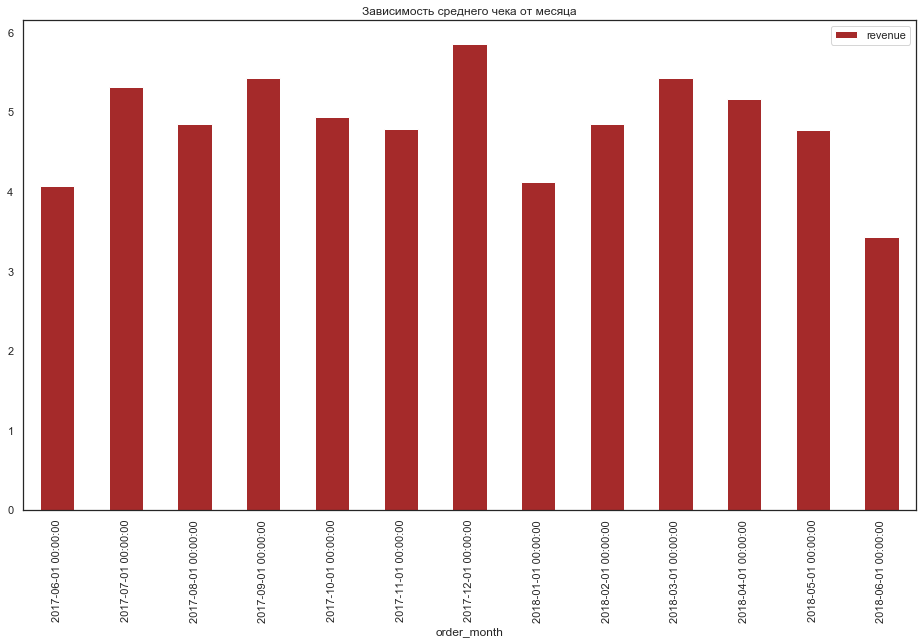

In [63]:
(orders
 .groupby('order_month')
 .agg({'revenue': 'mean'})
 .plot(kind='bar', color = '#a52a2a', figsize=(16,9), legend=True, title='Зависимость среднего чека от месяца', rot=90));

In [64]:
orders.groupby('order_month').agg({'revenue': 'mean'}).mean()

revenue    4.8387
dtype: float64

#### Рассчитаем, сколько денег приносят пользователи (LTV) <a id="step3.4"></a> 

In [65]:
orders = orders.merge(first_order, how = 'inner', on='uid')

In [66]:
orders

,order_time,revenue,uid,order_year,order_month,order_week,order_date,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01
...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:50:00,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:50:00,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:54:00,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:56:00,2018-05-01


In [67]:
ltv = orders[['first_order_month','order_month','revenue']].copy()

In [68]:
ltv

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,17.00
1,2017-06-01,2017-06-01,0.55
2,2017-06-01,2017-06-01,0.37
3,2017-06-01,2017-06-01,0.55
4,2017-06-01,2017-06-01,0.37
...,...,...,...
50410,2018-05-01,2018-05-01,4.64
50411,2018-05-01,2018-05-01,5.80
50412,2018-05-01,2018-05-01,0.30
50413,2018-05-01,2018-05-01,3.67


In [69]:
ltv['age'] = ((ltv['order_month']-ltv['first_order_month']) / np.timedelta64(1,'M')).round().astype('int')

In [70]:
ltv

,first_order_month,order_month,revenue,age
0,2017-06-01,2017-06-01,17.00,0
1,2017-06-01,2017-06-01,0.55,0
2,2017-06-01,2017-06-01,0.37,0
3,2017-06-01,2017-06-01,0.55,0
4,2017-06-01,2017-06-01,0.37,0
...,...,...,...,...
50410,2018-05-01,2018-05-01,4.64,0
50411,2018-05-01,2018-05-01,5.80,0
50412,2018-05-01,2018-05-01,0.30,0
50413,2018-05-01,2018-05-01,3.67,0


In [71]:
ltv = ltv.groupby(['first_order_month','age']).agg({'revenue':'sum'})

In [72]:
ltv

revenue
first_order_month age          
2017-06-01        0     9557.49
                  1      981.82
                  2      885.34
                  3     1931.30
                  4     2068.58
...                         ...
2018-03-01        2     1114.87
2018-04-01        0    10600.69
                  1     1209.92
2018-05-01        0    13925.76
2018-06-01        0        3.42

[79 rows x 1 columns]

In [73]:
ltv_table = ltv.pivot_table(index='first_order_month', columns='age', values='revenue', aggfunc='sum')

In [74]:
ltv_table

ltv_table.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,9557.49,981.82,885.34,1931.3,2068.58,1487.92,1922.74,1176.56,1119.15,1225.51,1155.66,519.62
2017-07-01,11557.65,644.61,1199.05,690.31,339.97,300.08,231.16,272.72,310.05,282.96,299.36,
2017-08-01,7228.83,646.63,628.12,536.05,676.85,388.45,288.61,554.86,400.33,257.53,,
2017-09-01,14568.53,2884.49,1344.52,10261.5,1033.84,1670.08,1810.85,627.57,474.92,,,
2017-10-01,21716.20,2325.21,830.65,682.01,657.77,522.37,368.1,501.14,,,,
2017-11-01,21036.26,1629.27,814.39,1326.13,604.04,219.88,469.02,,,,,
2017-12-01,20767.49,1141.22,4054.7,4669.1,1371.57,1481.66,,,,,,
2018-01-01,13949.50,994.22,1026.34,481.59,211.48,,,,,,,
2018-02-01,15177.16,1015.98,286.66,270.7,,,,,,,,


In [75]:
ltv_table = ltv_table.cumsum(axis=1)

In [76]:
ltv_table

ltv_table.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,9557.49,10539.3,11424.6,13355.9,15424.5,16912.5,18835.2,20011.8,21130.9,22356.4,23512.1,24031.7
2017-07-01,11557.65,12202.3,13401.3,14091.6,14431.6,14731.7,14962.8,15235.5,15545.6,15828.6,16127.9,
2017-08-01,7228.83,7875.46,8503.58,9039.63,9716.48,10104.9,10393.5,10948.4,11348.7,11606.3,,
2017-09-01,14568.53,17453,18797.5,29059.1,30092.9,31763,33573.8,34201.4,34676.3,,,
2017-10-01,21716.20,24041.4,24872.1,25554.1,26211.8,26734.2,27102.3,27603.4,,,,
2017-11-01,21036.26,22665.5,23479.9,24806,25410.1,25630,26099,,,,,
2017-12-01,20767.49,21908.7,25963.4,30632.5,32004.1,33485.7,,,,,,
2018-01-01,13949.50,14943.7,15970.1,16451.6,16663.1,,,,,,,
2018-02-01,15177.16,16193.1,16479.8,16750.5,,,,,,,,


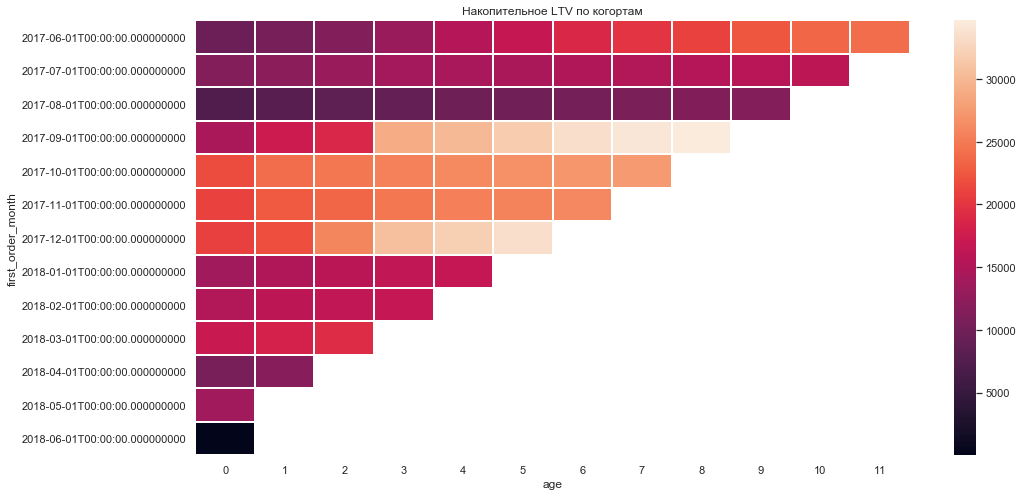

In [77]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Накопительное LTV по когортам')
sns.heatmap(ltv_table, linewidths=1);
#убрала подписи к ячейкам осознанно: цифры достаточно большие и сливаются, по цветам легко ориентироваться 👌

In [78]:
cohort_sizes_orders = orders.groupby('first_order_month').agg({'uid': 'nunique'}).rename(columns={'uid':'n_orders'}).reset_index()

In [79]:
cohort_sizes_orders = cohort_sizes_orders.set_index('first_order_month')

In [80]:
ltv_table = cohort_sizes_orders[['n_orders']].join(ltv_table)

In [81]:
ltv_table = ltv_table.div(ltv_table['n_orders'], axis=0).drop(columns = ['n_orders'])

In [82]:
ltv_table

ltv_table.fillna('')

,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,5.20974,5.64738,6.60205,7.62458,8.36008,9.31052,9.89212,10.4453,11.0511,11.6224,11.8792
2017-07-01,6.010218,6.34543,6.96896,7.32794,7.50473,7.66077,7.78098,7.9228,8.08404,8.23118,8.38685,
2017-08-01,5.276518,5.74851,6.20699,6.59827,7.09232,7.37586,7.58653,7.99153,8.28374,8.47172,,
2017-09-01,5.644529,6.76212,7.28305,11.2588,11.6594,12.3065,13.0081,13.2512,13.4352,,,
2017-10-01,5.003733,5.5395,5.73089,5.88803,6.03959,6.15996,6.24477,6.36024,,,,
2017-11-01,5.154683,5.55392,5.75347,6.07842,6.22644,6.28032,6.39524,,,,,
2017-12-01,4.738191,4.99856,5.92366,6.98894,7.30187,7.63991,,,,,,
2018-01-01,4.135636,4.43039,4.73468,4.87745,4.94015,,,,,,,
2018-02-01,4.156987,4.43526,4.51378,4.58792,,,,,,,,


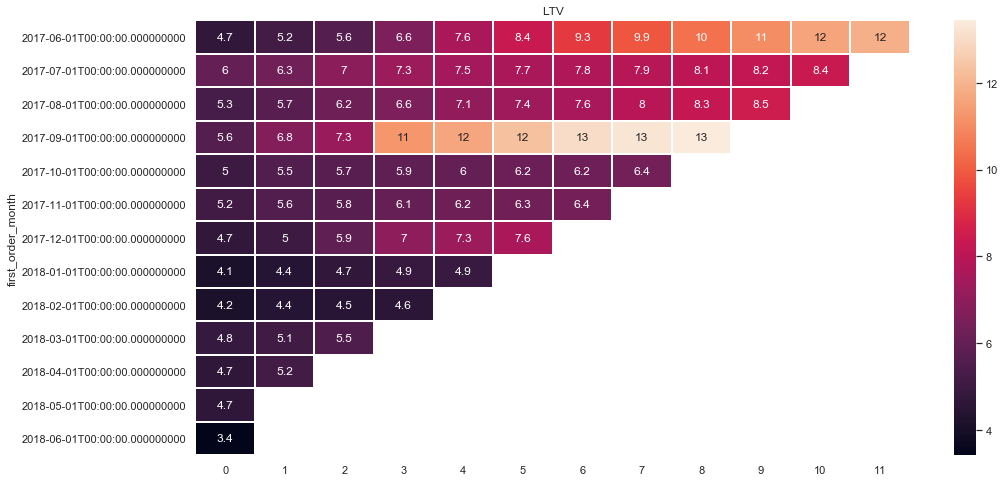

In [83]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('LTV')
sns.heatmap(ltv_table, annot=True, linewidths=1);

### Вывод

Чаще всего решение о покупке принимается достаточно быстро, половина покупок сделана через 16 минут после первого визита. Скорее всего пользователи приходят на сайт уже с решением купить билеты.

Пик продаж пришелся на осень и зиму 2017-2018 гг. Билеты в театр/на концерт — отличный подарок :)

Средний чек — 4.8387. Максимальное значение среднего чека замечено в декабре 2017 года.

Максимальную прибыль принесли пользователи, которые присоединились с сентября по декабрь, они принесли сервису существенные суммы уже в первый месяц использования. Максимальное значение LTV в расчете на покупателя у когорт 2017-06-01 и 2017-09-01.

### Шаг 4. Изучение маркетинга <a id="step4"></a> 

#### Проверим, сколько денег потратили пользователи (всего / на каждый источник / по времени) <a id="step4.1"></a> 

In [84]:
costs

,source_id,date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [85]:
all_costs = costs['costs'].sum()
all_costs

329131.62

In [86]:
marketing_costs = costs.rename(columns={'date':'session_date'})

In [87]:
marketing_costs = marketing_costs.set_index(['source_id','session_date'])

In [88]:
marketing_costs

costs
source_id session_date       
1         2017-06-01    75.20
          2017-06-02    62.25
          2017-06-03    36.53
          2017-06-04    55.00
          2017-06-05    57.08
...                       ...
10        2018-05-27     9.92
          2018-05-28    21.26
          2018-05-29    11.32
          2018-05-30    33.15
          2018-05-31    17.60

[2542 rows x 1 columns]

In [89]:
costs_for_source = costs.groupby('source_id')['costs'].sum()

In [90]:
costs_for_source.sort_values(ascending=False)

source_id
3     141321.63
4      61073.60
5      51757.10
2      42806.04
1      20833.27
10      5822.49
9       5517.49
Name: costs, dtype: float64

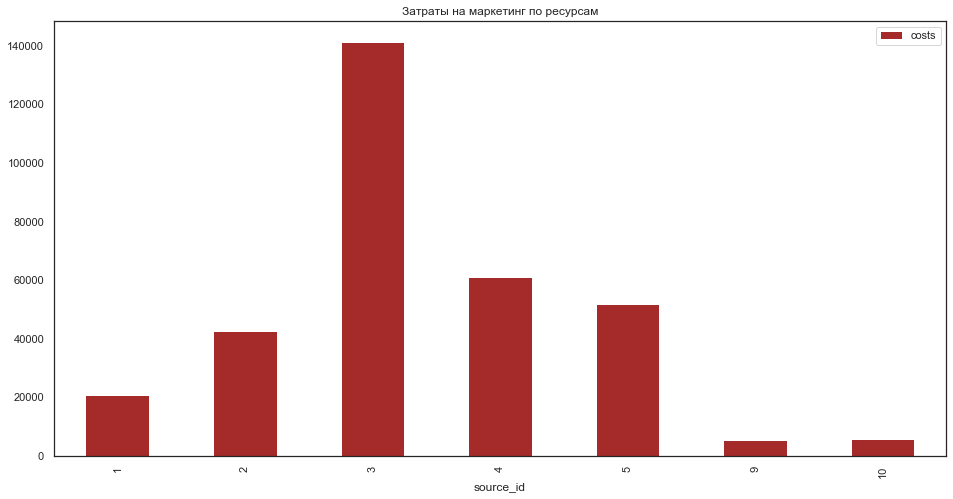

In [91]:
costs_for_source.plot(kind='bar', y='source_id', color = '#a52a2a', 
          figsize=(16,8), legend=True, title='Затраты на маркетинг по ресурсам');

In [92]:
costs['month'] = costs['date'].astype('datetime64[M]')

In [93]:
monthly_costs = costs.groupby('month')['costs'].sum()

In [94]:
monthly_costs

month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

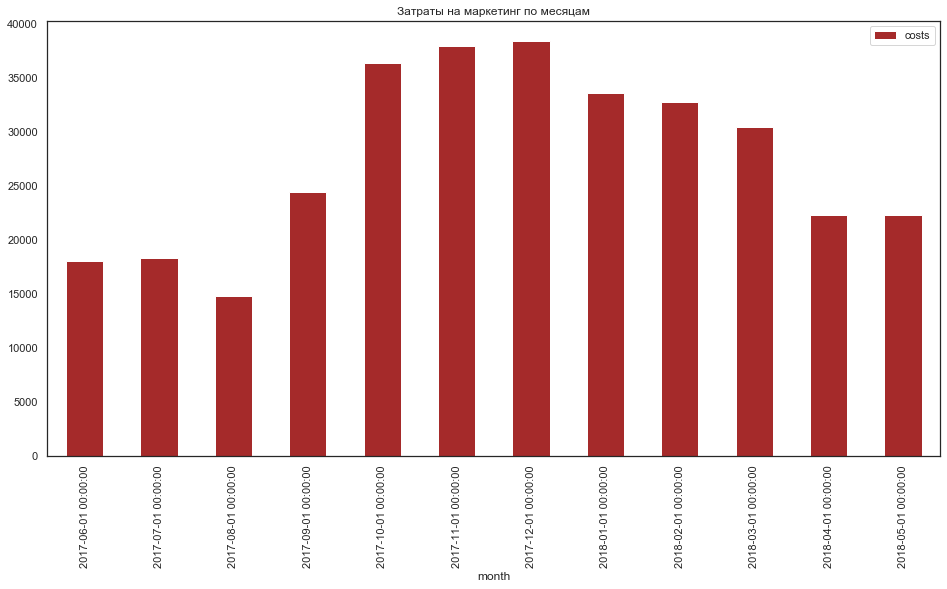

In [95]:
monthly_costs.plot(kind='bar', x='month', y='costs', color = '#a52a2a', 
          figsize=(16,8), legend=True, title='Затраты на маркетинг по месяцам');

#### Определим, сколько стоило привлечение одного покупателя из каждого источника <a id="step4.2"></a> 

In [96]:
first_visits_source = visits.query('start_session == first_session_date')[['uid','first_session_date','device','source_id','session_date','first_session_month']]

In [97]:
first_visits_source

,uid,first_session_date,device,source_id,session_date,first_session_month
0,16879256277535980062,2017-12-20 17:20:00,touch,4,2017-12-20,2017-12-01
1,104060357244891740,2018-02-19 16:53:00,desktop,2,2018-02-19,2018-02-01
2,7459035603376831527,2017-07-01 01:54:00,touch,5,2017-07-01,2017-07-01
4,16174680259334210214,2018-03-09 20:05:00,desktop,4,2018-03-09,2018-03-01
5,9969694820036681168,2017-12-27 14:06:00,desktop,3,2017-12-27,2017-12-01
...,...,...,...,...,...,...
359393,12734910664455613822,2018-04-23 21:11:00,desktop,10,2018-04-23,2018-04-01
359394,6761309174945977743,2017-11-08 13:39:00,desktop,4,2017-11-08,2017-11-01
359395,11102751930812818282,2017-07-31 12:13:00,desktop,3,2017-07-31,2017-07-01
359396,272012551460639309,2018-03-20 15:11:00,desktop,4,2018-03-20,2018-03-01


In [98]:
source_orders = orders.merge(first_visits_source, on='uid', how='inner')

In [99]:
source_orders

,order_time,revenue,uid,order_year,order_month,order_week,order_date,first_order_date,first_order_month,first_session_date,device,source_id,session_date,first_session_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:09:00,desktop,1,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:14:00,desktop,2,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:25:00,desktop,2,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:14:00,desktop,2,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017,2017-06-01,2017-06-01,2017-06-01,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:31:00,desktop,3,2017-06-01,2017-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:50:00,2018-05-01,2018-05-31 09:11:00,touch,4,2018-05-31,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:50:00,2018-05-01,2018-05-31 23:05:00,desktop,10,2018-05-31,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:54:00,2018-05-01,2018-05-31 23:52:00,desktop,3,2018-05-31,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018,2018-05-01,2018-05-31,2018-05-31,2018-05-31 23:56:00,2018-05-01,2017-10-23 12:32:00,desktop,3,2017-10-23,2017-10-01


In [100]:
source_orders = source_orders.groupby('source_id').agg({'revenue':'sum', 'uid':'nunique'}).rename(columns={'revenue':'total_revenue', 'uid':'n_buyers'})

In [101]:
source_orders

,total_revenue,n_buyers
source_id,,
1,31090.55,2899
2,46923.61,3506
3,54511.24,10473
4,56696.83,10296
5,52624.02,6931
7,1.22,1
9,5759.40,1088
10,4450.33,1329


In [102]:
table_source = source_orders.merge(costs_for_source, on='source_id', how='outer')

In [103]:
table_source

,total_revenue,n_buyers,costs
source_id,,,
1,31090.55,2899,20833.27
2,46923.61,3506,42806.04
3,54511.24,10473,141321.63
4,56696.83,10296,61073.60
5,52624.02,6931,51757.10
7,1.22,1,NaN
9,5759.40,1088,5517.49
10,4450.33,1329,5822.49


In [104]:
table_source['cac'] = table_source['costs'] / table_source['n_buyers']

In [105]:
table_source

,total_revenue,n_buyers,costs,cac
source_id,,,,
1,31090.55,2899,20833.27,7.186364
2,46923.61,3506,42806.04,12.209367
3,54511.24,10473,141321.63,13.493901
4,56696.83,10296,61073.60,5.931779
5,52624.02,6931,51757.10,7.467479
7,1.22,1,NaN,NaN
9,5759.40,1088,5517.49,5.071222
10,4450.33,1329,5822.49,4.381106


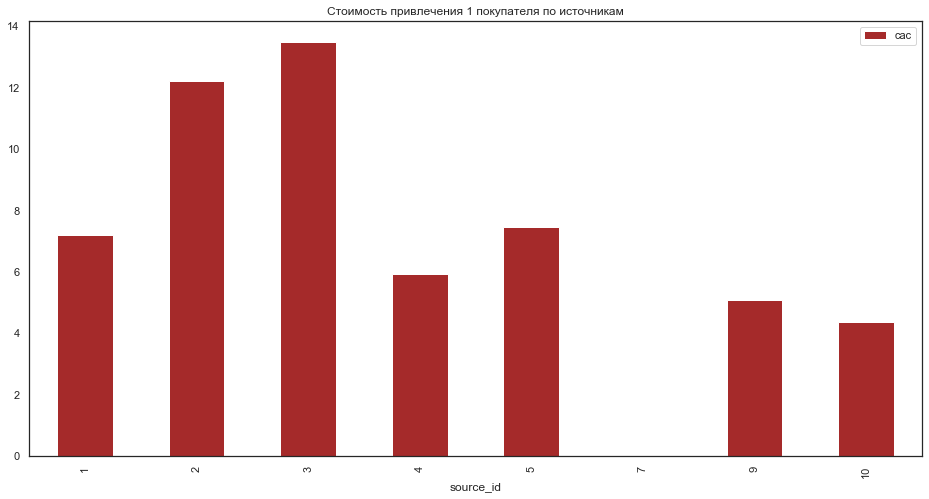

In [106]:
table_source.plot(kind='bar', y='cac', color = '#a52a2a', 
          figsize=(16,8), legend=True, title='Стоимость привлечения 1 покупателя по источникам');

#### Рассчитаем, на сколько окупились расходы (ROI) <a id="step4.3"></a> 

In [107]:
ltv = ltv.reset_index()

In [108]:
cohort_sizes_orders = orders.groupby('first_order_month').agg({'uid': 'nunique'}).rename(columns={'uid':'n_orders'}).reset_index()

In [109]:
result = pd.merge(ltv, monthly_costs, left_on='first_order_month', right_on='month')

In [110]:
result = result.merge(cohort_sizes_orders, on='first_order_month')

In [111]:
result['ltv'] = result['revenue'] / result['n_orders']

In [112]:
result['cac'] = result['costs'] / result['n_orders']

In [113]:
result['romi'] = result['ltv'] / result['cac']

In [114]:
result_table = result.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean')

In [115]:
result_table.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


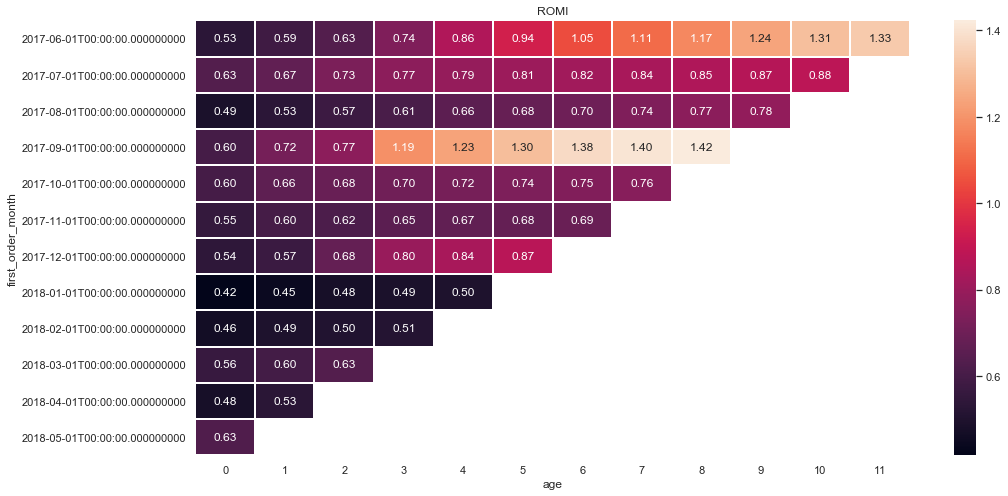

In [116]:
plt.figure(figsize = (16, 8))
plt.title('ROMI')
sns.heatmap(result_table.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='white')
plt.show();

In [117]:
result_table.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

Посчитаем также ROMI в целом по источникам:

In [118]:
table_source

,total_revenue,n_buyers,costs,cac
source_id,,,,
1,31090.55,2899,20833.27,7.186364
2,46923.61,3506,42806.04,12.209367
3,54511.24,10473,141321.63,13.493901
4,56696.83,10296,61073.60,5.931779
5,52624.02,6931,51757.10,7.467479
7,1.22,1,NaN,NaN
9,5759.40,1088,5517.49,5.071222
10,4450.33,1329,5822.49,4.381106


In [119]:
table_source['ltv'] = table_source['total_revenue'] / table_source['n_buyers']

In [120]:
table_source['romi'] = table_source['ltv'] / table_source['cac']

In [121]:
table_source

,total_revenue,n_buyers,costs,cac,ltv,romi
source_id,,,,,,
1,31090.55,2899,20833.27,7.186364,10.724577,1.492351
2,46923.61,3506,42806.04,12.209367,13.383802,1.096191
3,54511.24,10473,141321.63,13.493901,5.204931,0.385725
4,56696.83,10296,61073.60,5.931779,5.506685,0.928336
5,52624.02,6931,51757.10,7.467479,7.592558,1.016750
7,1.22,1,NaN,NaN,1.220000,NaN
9,5759.40,1088,5517.49,5.071222,5.293566,1.043844
10,4450.33,1329,5822.49,4.381106,3.348631,0.764335


### Вывод:

Общие расходы на маркетинг составили 329131.62. На ресурс под номером 3 было потрачено максимальное количество денег (141321.63), что больше, чем в 2 раза затрат на ресурс 4. Остальные ресурсы получили ещё меньше денег. Больше всего денег на маркетинг тратили с октября по декабрь (в эти же месяцы было и больше покупок).

Дороже всех обошлось привлечение 1 покупателя из ресурса 3 — 13.49, а дешевле всего пришел покупатель из источника 10 — 4.38.

Окупаемость расходов сильно зависит от когорты, в среднем рассчитывать можно на 8 месяцев. Лидер по окупаемости затрат — источник номер 1 (показатель romi — 1.5)

## Выводы

В начале исследования изучили и подготовили данные к анализу (изменили типы данных, привели названия столбцов к нижнему регистру). Рассчитали метрики по визитам на сайт и покупкам. В исследовании анализировали данные за 2017 - 2018 гг.

По результатам ислледования появились следующие выводы:
1. В анализируемый период большинство визитов приходилось на десктопные девайсы (164523 заходов против 71345)
2. Сценарий использования сайта не рутинный, пользователи редко заходят на сайт повторно.
3. Чаще всего люди покупают и смотрят билеты в осенние и зимние месяцы. Летом трафик низкий: вероятно, билеты на летние фестивали/мероприятия покупаются заранее, театры не работают. Зимой трафик значительно выше: новогодние каникулы/подарки/времяпрепровождение в помещении.
4. Максимальную прибыль принесли пользователи, которые присоединились с сентября по декабрь, они принесли сервису существенные суммы уже в первый месяц использования.
5. Стоимость привлечения покупателей через различные ресурсы значительно различается. Стоит пересмотреть затраты на ресурс номер 3 (было потрачено наибольшее количество средств, выхлоп получился маленький).
6. Стоит проверить источник трафика номер 7. Тратим ли мы что-то на привлечение пользователей? Почему пришел только один покупатель через этот канал?
7. Вопрос удержания пользователей достаточно острый: если пользователи перстают возвращаться, окупить затраты на их привлечение не получается и этот процесс затягивается. Возможно, стоит перераспределить маркетинговый бюджет и больше работать над удержанием пользователей.
8. Интересно было бы посмотреть на соотношение девайсов сейчас, но для анализируемого периода стоило бы проверить UI/UX дизайн сайта на мобильных устройствах. Сайтом неудобно пользоваться или что-то работает некорректно?